In [16]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
rng = np.random.default_rng()

In [17]:
def ordered_state(width):
    return np.exp(2j * np.pi * np.zeros((width,width,width,width,4)))

def disordered_state(width):
    return np.exp(2j * np.pi * np.random.rand(width,width,width,width,4))

In [27]:
def run_lattice_heatbath(U_state,beta,n):
    """Perform n heatbath updates on the lattice state U_state."""
    for _ in range(n):
        lattice_heatbath_update(U_state,beta)

def lattice_heatbath_update(U_state,beta):
    """Perform a random heatbath update on the lattice state U_state."""
    width = len(U_state)
    link_index = random_link_index(width)
    U_state[link_index] = sample_link_variable(U_state,beta,link_index)

def random_link_index(width):
    """Return a random link index (n_x,n_y,n_z,kappa)"""
    return tuple(rng.integers(0,[width,width,width,width,4]))

def sample_link_variable(state,beta,link_index):
    """Sample link variable U = exp(i*theta)."""
    link_variable_sum = relevant_link_variable_sum(state,link_index)
    alpha = beta*np.real(link_variable_sum)
    phi = np.angle(link_variable_sum)
    while True:
        Z = rng.uniform(0,1)
        x = -1 + np.log(1 + (np.exp(2*alpha) - 1)*Z)/alpha

        Q = np.exp(alpha*(np.cos(np.pi/2*(1-x))-x))
        Q_max = np.exp(0.2105137*alpha)

        Z_prime = rng.uniform(0,1)
        if Q/Q_max > Z_prime:
            theta = np.pi*(1-x)/2 - phi
            return np.exp(1j*theta)

def relevant_link_variable_sum(state,link_index):
    """Return the sum of the link variables present in the plaquettes containing the relevant link,
    without the contribution of the link itself."""
    width = len(state)
    base = np.array(link_index[:4])
    kappa = link_index[-1]
    kappa_hat = get_unit_vector(kappa)

    result = 0
    for nu in range(4):
        if nu != kappa:
            nu_hat = get_unit_vector(nu)
            contribution = state[get_lattice_vector(base+kappa_hat,width)][nu]
            contribution *= state[get_lattice_vector(base+nu_hat,width)][kappa]
            contribution *= state[get_lattice_vector(base,width)][nu]
            result += contribution

    return result

def get_unit_vector(index):
    """Return the unit vector from the dimension index."""
    vector = np.zeros(4).astype(int)
    vector[index] = 1
    return vector

def get_plaquette_values(state,vertex,mu_vector,nu_vector):
    """Return the plaquette link variable values from the plaquette vertex and two plane vectors."""
    width = len(state)

    vertex = np.array(vertex)
    mu_vector, nu_vector = np.array(mu_vector), np.array(nu_vector)
    mu_index, nu_index = get_unit_vector_index(mu_vector), get_unit_vector_index(nu_vector)

    return [
        state[get_lattice_vector(vertex,width)][mu_index],
        state[get_lattice_vector(vertex + mu_vector,width)][nu_index],
        np.conj(state[get_lattice_vector(vertex + mu_vector + nu_vector,width)][nu_index]),
        np.conj(state[get_lattice_vector(vertex,width)][nu_index])
    ]

def get_unit_vector_index(vector):
    """Return the index of the unit vector."""
    return np.flatnonzero(vector)[0].astype(int)

def get_lattice_vector(vector,width):
    """Get the lattice vector periodic with the lattice width."""
    return tuple(map(lambda i: i % width, vector))

In [19]:
def lattice_action(state):
    """Compute action of the lattice state."""
    action = 0
    plaquette_corners = get_unique_unoriented_plaquette_corners(len(state))
    for corners in plaquette_corners:
        if len(get_plane_vectors_from_corners(corners)) == 2:
            values = get_plaquette_values_from_corners(state,corners)
            action += 1 - np.real(np.prod(values))
    return action

def get_unique_unoriented_plaquette_corners(width):
    """Return pairs of vertices forming the corners of only unique and unoriented lattice plaquettes."""
    unique_unoriented_corners = []
    for corners in get_plaquettes_corners(width):
        sorted_corners = tuple(sorted(corners))
        if sorted_corners not in unique_unoriented_corners:
            unique_unoriented_corners.append(sorted_corners)
    return unique_unoriented_corners

def get_plaquettes_corners(width):
    """Return pairs of vertices forming the corners of lattice plaquettes."""
    plaquette_corners = []
    for vertex in lattice_vertices(width):
        for mu_vector,nu_vector in get_plane_vectors():
            plaquette_corners.append([
                get_lattice_vector(vertex,width),
                get_lattice_vector(vertex + mu_vector,width),
                get_lattice_vector(vertex + nu_vector,width),
                get_lattice_vector(vertex + mu_vector + nu_vector,width)
            ])
    return plaquette_corners

def lattice_vertices(width):
    """Compute the vertices of the lattice with given width."""
    vertices = []
    for n_x in range(width):
        for n_y in range(width):
            for n_z in range(width):
                for n_t in range(width):
                    vertex = (n_x,n_y,n_z,n_t)
                    vertices.append(vertex)
    return vertices

def get_plane_vectors():
    """Return pairs of vectors (mu_vector,nu_vector) forming unique planes on the lattice."""
    plane_vectors = []
    for mu in range(4):
        for nu in range(4):
            if mu < nu:
                plane_vectors.append((get_unit_vector(mu),get_unit_vector(nu)))
    return plane_vectors

def get_plaquette_values_from_corners(state,corners):
    """Return the plaquette link variable values from the four corners of the plaquette."""
    corners = tuple(sorted(corners))

    vertex = np.array(corners[0])
    plane_vectors = get_plane_vectors_from_corners(corners)
    mu_vector, nu_vector = np.array(plane_vectors[0]), np.array(plane_vectors[1])

    if get_unit_vector_index(mu_vector) > get_unit_vector_index(nu_vector):
        mu_vector, nu_vector = nu_vector, mu_vector

    return get_plaquette_values(state,vertex,mu_vector,nu_vector)

def get_plane_vectors_from_corners(corners):
    plane_vectors = []
    for i in range(4):
        for j in range(4):
            difference_vector = tuple(np.abs(np.array(corners[i]) - np.array(corners[j])))
            is_unit_vector = np.linalg.norm(difference_vector) == 1.0
            if is_unit_vector and difference_vector not in plane_vectors:
                plane_vectors.append(difference_vector)
    return plane_vectors

In [20]:
def run_simulation(state,beta,k,n,measurements):
    """Run the simulation with k equilibration sweeps and n measurement sweeps.
    Returns the action measurement results."""
    num_links = 4*len(state)**4

    # equilibrate
    run_lattice_heatbath(state,beta,k*num_links)

    # measure
    results = np.empty(measurements)
    for i in range(measurements):
        run_lattice_heatbath(state,beta,n*num_links)
        results[i] = lattice_action(state)
        print(i)

    return results

In [28]:
width = 4
beta = 0.55
equil_sweeps = 0
measure_sweeps = 1
measurements = 360

with h5py.File('lattice.hdf5','a') as f:
    if not "beta0.55-average-action-per-iterations" in f:
        U_state = ordered_state(width)
        action_measurements = run_simulation(U_state,beta,equil_sweeps,measure_sweeps,measurements)
        f.create_dataset("beta0.55-average-action-per-iterations",data=action_measurements)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Mean: 0.562193296725746


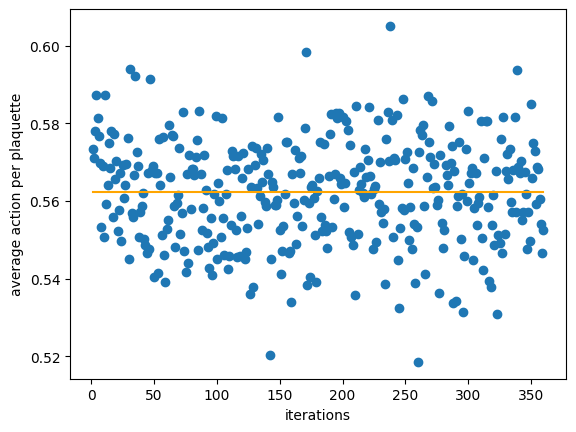

In [29]:
with h5py.File('lattice.hdf5','r') as f:
    action_measurements = f["beta0.55-average-action-per-iterations"][()]

    num_plaquettes = len(get_unique_unoriented_plaquette_corners(width))
    actions = [action / num_plaquettes for action in action_measurements]

    plt.scatter(np.linspace(1,measurements,measurements),actions)
    plt.xlabel("iterations")
    plt.ylabel("average action per plaquette")

    plt.plot(np.linspace(1,measurements,measurements),[np.mean(actions) for _ in range(measurements)],color="orange")

    print(f"Mean: {np.mean(actions)}")

In [30]:
width = 4
beta = 1.000
equil_sweeps = 0
measure_sweeps = 1
measurements = 360

with h5py.File('lattice.hdf5','a') as f:
    if not "beta1-average-action-per-iterations" in f:
        state = ordered_state(width)
        action_measurements = run_simulation(state,beta,equil_sweeps,measure_sweeps,measurements)
        f.create_dataset("beta1-average-action-per-iterations",data=action_measurements)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Mean: 0.5534211519698656


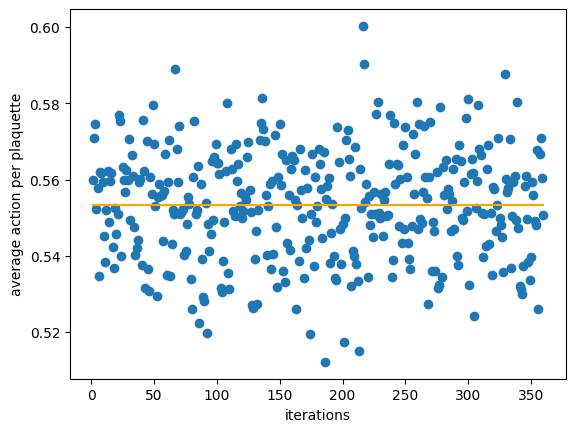

In [31]:
with h5py.File('lattice.hdf5','r') as f:
    action_measurements = f["beta1-average-action-per-iterations"][()]

    num_plaquettes = len(get_unique_unoriented_plaquette_corners(width))
    actions = [action / num_plaquettes for action in action_measurements]

    plt.scatter(np.linspace(1,measurements,measurements),actions)
    plt.xlabel("iterations")
    plt.ylabel("average action per plaquette")

    plt.plot(np.linspace(1,measurements,measurements),[np.mean(actions) for _ in range(measurements)],color="orange")

    print(f"Mean: {np.mean(actions)}")

In [32]:
width = 4
beta = 5.5
equil_sweeps = 0
measure_sweeps = 1
measurements = 80

with h5py.File('lattice.hdf5','a') as f:
    if not "beta5.5-average-action-per-iterations" in f:
        state = ordered_state(width)
        action_measurements = run_simulation(state,beta,equil_sweeps,measure_sweeps,measurements)

        f.create_dataset("beta5.5-average-action-per-iterations",data=action_measurements)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


Mean: 0.25618000860120993


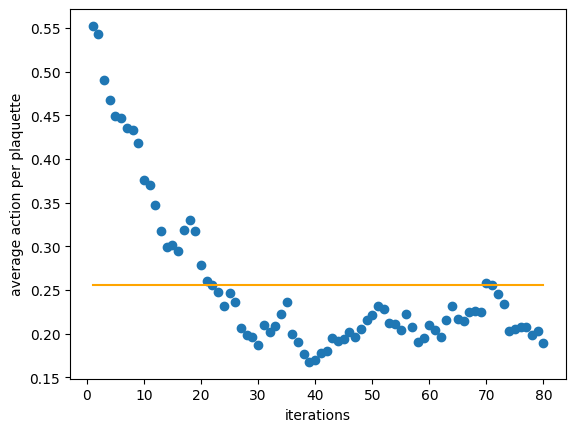

In [33]:
with h5py.File('lattice.hdf5','r') as f:
    action_measurements = f["beta5.5-average-action-per-iterations"][()]

    num_plaquettes = len(get_unique_unoriented_plaquette_corners(width))
    actions = [action / num_plaquettes for action in action_measurements]

    plt.scatter(np.linspace(1,measurements,measurements),actions)
    plt.xlabel("iterations")
    plt.ylabel("average action per plaquette")

    plt.plot(np.linspace(1,measurements,measurements),[np.mean(actions) for _ in range(measurements)],color="orange")

    print(f"Mean: {np.mean(actions)}")